# Comparison of robustness curves for l_2 and l_inf norms and models trained with different robust training methods

In [ ]:
import os
os.chdir("../")
import sys
import json
from argparse import Namespace
import numpy as np
from sklearn import metrics
from sklearn.metrics import pairwise_distances as dist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper')

import provable_robustness_max_linear_regions.data as dt
from generate_robustness_curves import generate_curve_data
from utils import NumpyEncoder

## Plot settings:

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)

# dictionary that maps color string to 'good looking' seaborn colors that are easily distinguishable
colors = {
    "orange": sns.xkcd_rgb["yellowish orange"],
    "red": sns.xkcd_rgb["pale red"],
    "green": sns.xkcd_rgb["medium green"],
    "blue": sns.xkcd_rgb["denim blue"],
    "yellow": sns.xkcd_rgb["amber"],
    "purple": sns.xkcd_rgb["dusty purple"],
    "cyan": sns.xkcd_rgb["cyan"]
}

## Calculate robustness curves:
Estimated runtime (if no file with data is present): 2 days

In [3]:
def load_from_json(file_name):

    if not os.path.exists("res/" + file_name + ".json"):
        return None
    else:
        with open("res/" + file_name + ".json", 'r') as fp:
            loaded_json =  json.load(fp)

            for key in loaded_json.keys():
                loaded_json[key]["x"] = np.array(loaded_json[key]["x"])
                loaded_json[key]["y"] = np.array(loaded_json[key]["y"])

                loaded_json[key]["y"][np.isnan(loaded_json[key]["x"])] = 1.0
                loaded_json[key]["x"] = np.nan_to_num(loaded_json[key]["x"], nan = np.nanmax(loaded_json[key]["x"]))

            return loaded_json
        
def save_to_json(dictionary, file_name):
        
    if not os.path.exists("res"):
        os.makedirs("res")

    with open("res/" + file_name + ".json", 'w') as fp:
        json.dump(dictionary, fp, cls = NumpyEncoder)


dataset_to_model_path = {"mnist": "provable_robustness_max_linear_regions/models/mmr+at/2019-02-17 01:54:16 dataset=mnist nn_type=cnn_lenet_small p_norm=inf lmbd=0.5 gamma_rb=0.2 gamma_db=0.2 ae_frac=0.5 epoch=100.mat", 
                        "fmnist": "provable_robustness_max_linear_regions/models/mmr+at/2019-02-16 12:08:43 dataset=fmnist nn_type=cnn_lenet_small p_norm=inf lmbd=2.0 gamma_rb=0.15 gamma_db=0.15 stage1hpl=10 ae_frac=0.5 epoch=100.mat",
                         "gts": "provable_robustness_max_linear_regions/models/mmr+at/2019-02-17 23:43:21 dataset=gts nn_type=cnn_lenet_small p_norm=inf lmbd=1.0 gamma_rb=6.0 gamma_db=6.0 ae_frac=0.5 epoch=100.mat",
                         "cifar10": "provable_robustness_max_linear_regions/models/mmr+at/2019-02-17 23:20:04 dataset=cifar10 nn_type=cnn_lenet_small p_norm=inf lmbd=0.1 gamma_rb=3.0 gamma_db=3.0 ae_frac=0.5 epoch=100.mat"
                        }

n_points = 10000

robustness_curve_data = dict()

for dataset in ["mnist", "fmnist", "gts", "cifar10"]:
    
    robustness_curve_data[dataset] = load_from_json("appr_rb_curve_l_sup_model_and_dataset={}_n_points={}".format(dataset, n_points))
                                           
    if not robustness_curve_data[dataset]:

        args = Namespace()

        args.dataset = dataset
        args.n_points = n_points
        args.model_path = dataset_to_model_path[dataset]
        args.nn_type = "cnn"
        args.norms = ["inf"]
        args.save = False
        args.plot = False

        robustness_curve_data[dataset] = generate_curve_data(args)

        save_to_json(robustness_curve_data[dataset], "appr_rb_curve_l_sup_model_and_dataset={}_n_points={}".format(dataset, n_points))     

## Plot:

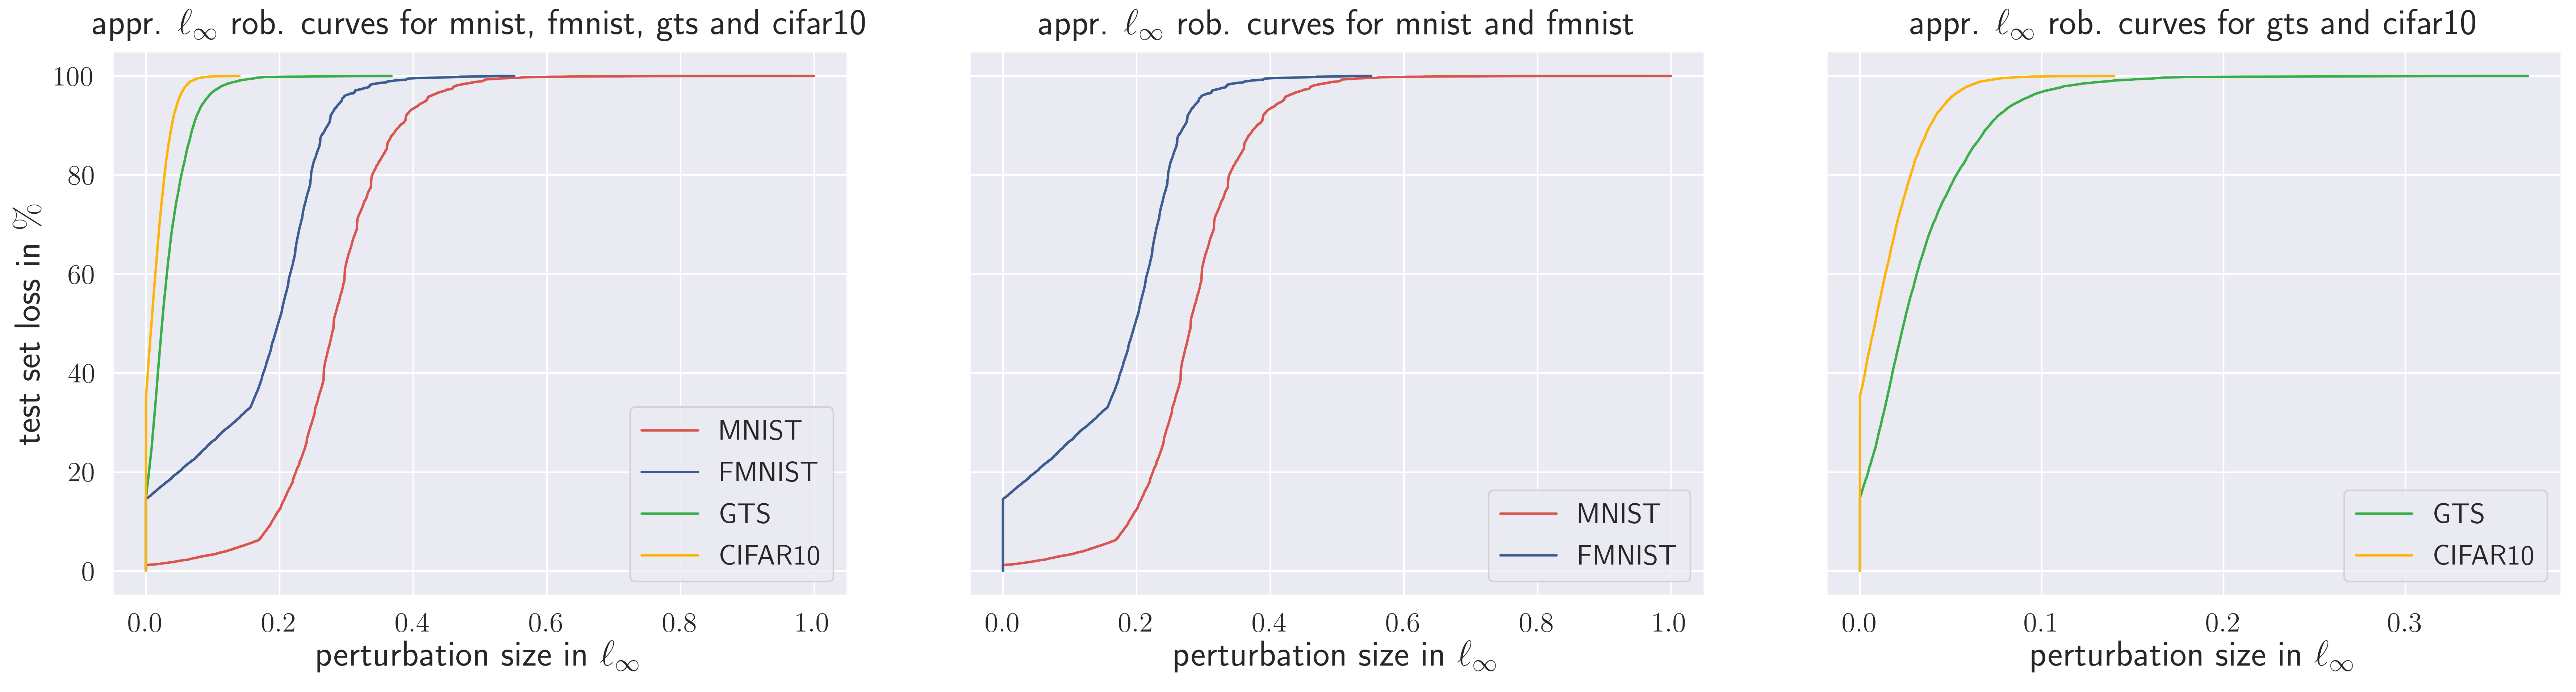

In [4]:
# name to save the plot
save_name = "fig_rc_sup_different_datasets"

# number of model types and parameter combinations
n_cols = 3
n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize = (6 * n_cols, 5 * n_rows), dpi=400, sharey=True)

dataset_to_color = {"mnist" : colors["red"], "fmnist": colors["blue"], "gts" : colors["green"], "cifar10": colors["yellow"]}
dataset_to_label = {"mnist" : "MNIST", "fmnist": "FMNIST", "gts" : "GTS", "cifar10": "CIFAR10"}

for dataset in ["mnist", "fmnist", "gts", "cifar10"]:

    ax[0].plot(robustness_curve_data[dataset]["inf"]["x"], robustness_curve_data[dataset]["inf"]["y"] * 100, c = dataset_to_color[dataset], label = "{}".format(dataset_to_label[dataset]))

for dataset in ["mnist", "fmnist"]:

    ax[1].plot(robustness_curve_data[dataset]["inf"]["x"], robustness_curve_data[dataset]["inf"]["y"] * 100, c = dataset_to_color[dataset], label = "{}".format(dataset_to_label[dataset]))

for dataset in ["gts", "cifar10"]:


    ax[2].plot(robustness_curve_data[dataset]["inf"]["x"], robustness_curve_data[dataset]["inf"]["y"] * 100, c = dataset_to_color[dataset], label = "{}".format(dataset_to_label[dataset]))

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_xlabel("perturbation size in $\ell_\infty$")
ax[1].set_xlabel("perturbation size in $\ell_\infty$")
ax[2].set_xlabel("perturbation size in $\ell_\infty$")

ax[0].set_ylabel("test set loss in $\%$")

ax[0].set_title("appr. $\ell_\infty$ rob. curves for mnist, fmnist, gts and cifar10")
ax[1].set_title("appr. $\ell_\infty$ rob. curves for mnist and fmnist")
ax[2].set_title("appr. $\ell_\infty$ rob. curves for gts and cifar10")

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name))